In [1]:
import numpy as np
import scipy
from scipy import spatial

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## This is the solution of nonlinear 2nd order PDEs.


This solution should work for general elliptic PDEs such as
$$
\frac{\partial^2 u(x,y)}{\partial x^2 } ~+~ \frac{\partial^2 u(x,y)}{\partial y^2 } ~=~ f(x,y)
$$
But we restrict it to simple 1d systems described by the following equation

$$
\frac{d}{dx} (k(x) \frac{du}{dx} ) ~=~ \frac{dk(x)}{dx}\frac{du}{dx} + k(x)\frac{d^2 u}{dx^2} ~=~ f(x)
$$

In [60]:
import torch
import numpy as np
import os
import time
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad

In [61]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = nn.Linear(1,80)
        self.mi  = nn.Linear(80,80)
        self.mi1  = nn.Linear(80,80)
        self.mi2 = nn.Linear(80,40)
        self.ol  = nn.Linear(40,1)
        #self.tn = nn.ReLU()
        self.tn  = nn.Tanh()
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self,x):
        u = x
        #print(u)
        hidden1 = self.il(u)
        hidden2 = self.mi(self.tn(hidden1))
        hidden2a = self.mi1(self.tn(hidden2))
        hidden3 = self.mi2(self.tn(hidden2a))
        out =     self.ol(self.tn(hidden3))
        return out

In [62]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

In [63]:
vxn  = 50
vx =np.linspace(0, np.pi, vxn) 
ix = torch.FloatTensor(vx).reshape(vxn,1)

We will look at 2 cases where we can verify the result.  We will use k(x) = x for both.
$$
case ~1 ~~~~ u ~=~ sin^2(x)
$$
$$
case ~2 ~~~~ u ~=~ sin^2(2x)
$$

In [64]:
def u_true(x):
    u = np.sin(x)**2
    return u

Now symbolically compute the dervatives
$$
\frac{du}{dx} ~=~ 2.0 \sin(x) \cos(x) ~=~  \sin(2x)
$$

$$
k(x) ~=~ x
$$
$$
\frac{d}{dx} (k(x) \frac{du}{dx} )~=~ \frac{d}{dx} (  x sin(2x)) ~=~ sin(2x)+2*x*cos(2x)
$$


$$
\frac{d}{dx} (x\frac{du}{dx} )~=~ sin(2x)+2xcos(2x)
$$

In [65]:
def f_true(x):
    f = np.sin(2.0*x)+2.0*x*np.cos(2*x)
    #f = 4.0*np.cos(2.0*x)
    return f

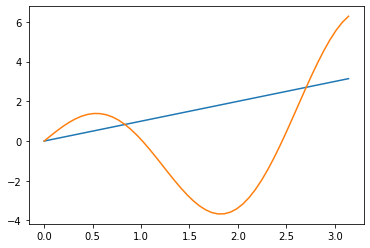

In [66]:
plt.plot(ix, ix)
plt.plot(ix, f_true(ix))

In [67]:
bndry = torch.FloatTensor([vx[0], vx[vxn-1]]).reshape(2,1)
Truebndry = torch.FloatTensor([0., 0.]).reshape(2,1)
mynet = Net()
mynet(bndry)

tensor([[0.2527],
        [0.2758]], grad_fn=<AddmmBackward>)

In [68]:
def Du(x):
    u = mynet(x)
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0] #nth_derivative(flat(u), wrt=x, n=1)
    z = u_x*x
    u_xx = grad(flat(z), x, create_graph=True, allow_unused=True)[0] #nth_derivative(flat(u), wrt=x, n=1)
    f = u_xx
    return f


In [69]:
mynet = Net()

In [70]:
import random
batches = []
fbatches = []
for i in range(20):
    b = random.choices(vx,k=10)
    bar = np.array(b)
    fb = f_true(bar)
    fb0 = torch.FloatTensor(fb).reshape(10,1)
    fb0.requires_grad=True
    ib = torch.FloatTensor(b).reshape(10,1)
    ib.requires_grad=True
    batches.append(ib)
    fbatches.append(fb0)
Du(batches[13])

tensor([[-0.0105],
        [-0.0066],
        [-0.0066],
        [-0.0214],
        [-0.0066],
        [-0.0092],
        [-0.0088],
        [-0.0161],
        [-0.0110],
        [-0.0153]], grad_fn=<AddBackward0>)

In [71]:
mynet = Net()
epocs = 3000
m = len(batches)
loss_fn = nn.MSELoss()
optimizerf = optim.SGD(mynet.parameters(), lr=0.0005)
optimizerbdry = optim.SGD(mynet.parameters(), lr=0.001)

loss_fn = nn.MSELoss()
for epoc in range(1, epocs):
    loss2tot =  0.0
    for i in range(len(batches)):
        batch_index = np.random.randint(0,m)
        b = batches[batch_index]
        fb = fbatches[batch_index]
        optimizerf.zero_grad()
        optimizerbdry.zero_grad()
        output_bndry = mynet(bndry)
        outputsf = Du(b)
        loss_bndry = loss_fn(output_bndry, Truebndry)
        lossf = loss_fn(outputsf, fb)
        lossf.backward(retain_graph=True)
        optimizerf.step()
        loss2tot += lossf
        loss_bndry.backward(retain_graph=True)
        optimizerbdry.step()
    if epoc % 50  == 0:
        loss = 0.0
        print('epoc %d bndry loss %f, f loss %f'%(epoc, float(loss_bndry), float(loss2tot))) # file=open('./elliptic_out.txt','a'))
    if epoc % 1000 == 0:
        torch.save(mynet.state_dict(), 'nonlinmodel')

epoc 50 bndry loss 0.200076, f loss 61.989479
epoc 100 bndry loss 0.000111, f loss 1.436094
epoc 150 bndry loss 0.003624, f loss 0.957255
epoc 200 bndry loss 0.000476, f loss 0.950041
epoc 250 bndry loss 0.000756, f loss 0.648400
epoc 300 bndry loss 0.000303, f loss 0.662985
epoc 350 bndry loss 0.000530, f loss 0.391052
epoc 400 bndry loss 0.000144, f loss 0.307978
epoc 450 bndry loss 0.000235, f loss 0.222816
epoc 500 bndry loss 0.000186, f loss 0.136610
epoc 550 bndry loss 0.000044, f loss 0.092650
epoc 600 bndry loss 0.000013, f loss 0.083790
epoc 650 bndry loss 0.000016, f loss 0.089004
epoc 700 bndry loss 0.000193, f loss 0.060169
epoc 750 bndry loss 0.000013, f loss 0.052670
epoc 800 bndry loss 0.000013, f loss 0.066963
epoc 850 bndry loss 0.000013, f loss 0.050933
epoc 900 bndry loss 0.000009, f loss 0.044755
epoc 950 bndry loss 0.000008, f loss 0.042402
epoc 1000 bndry loss 0.000012, f loss 0.048358
epoc 1050 bndry loss 0.000005, f loss 0.032774
epoc 1100 bndry loss 0.000002, f

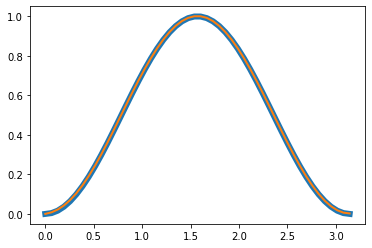

In [72]:
#mynet.load_state_dict(torch.load('nonlinmodel'))
ix = torch.FloatTensor(vx).reshape(vxn,1)
u = mynet(ix)
plt.plot(ix, u_true(ix) ,  linewidth=6)
plt.plot(ix, u.detach().numpy(), linewidth=2)


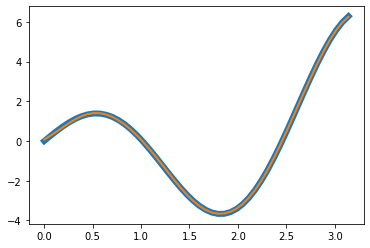

In [73]:
ix = torch.FloatTensor(vx).reshape(vxn,1)
plt.plot(ix, f_true(ix) ,  linewidth=6)
ix.requires_grad = True
du = Du(ix)
du = du.detach()
plt.plot(ix.detach(), du, linewidth=2)


version 2


In [38]:
def u_true(x):
    u = np.sin(2*x)**2
    return u/8.0

$$
\frac{du}{dx} ~=~ 2.0 \sin(2x) \cos(2x) ~=~  2.0 \sin(4x)/8.0
$$

$$
k(x) ~=~ x
$$
$$
\frac{d}{dx} (k(x) \frac{du}{dx} )~=~ \frac{d}{dx} (2  x \sin(4x)/8) ~=~ (2.0 \sin(4x)+2*x* \cos(4x)*4)/8
$$

In [39]:
def f_true(x):
    f = np.sin(4.0*x)/4.0+x*np.cos(4*x)
    #f = 4.0*np.cos(2.0*x)
    return f

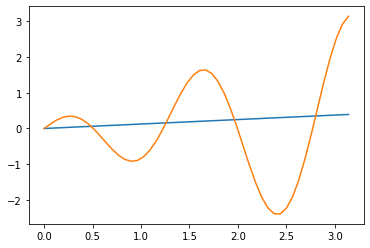

In [42]:
ix = torch.FloatTensor(vx).reshape(vxn,1)
plt.plot(ix, ix/8.0)
plt.plot(ix, f_true(ix))

In [43]:
mynet = Net()

In [44]:
def Du(x):
    u = mynet(x)
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0] #nth_derivative(flat(u), wrt=x, n=1)
    z = u_x*x
    u_xx = grad(flat(z), x, create_graph=True, allow_unused=True)[0] #nth_derivative(flat(u), wrt=x, n=1)
    f = u_xx
    return f


In [47]:
import random
batches = []
fbatches = []
for i in range(20):
    b = random.choices(vx,k=10)
    bar = np.array(b)
    fb = f_true(bar)
    fb0 = torch.FloatTensor(fb).reshape(10,1)
    fb0.requires_grad=True
    ib = torch.FloatTensor(b).reshape(10,1)
    ib.requires_grad=True
    batches.append(ib)
    fbatches.append(fb0)
Du(batches[13])

tensor([[-0.0066],
        [-0.0061],
        [-0.0034],
        [-0.0061],
        [-0.0020],
        [-0.0071],
        [ 0.0008],
        [ 0.0010],
        [-0.0043],
        [-0.0047]], grad_fn=<AddBackward0>)

In [50]:
#mynet = Net()
epocs = 3003
m = len(batches)
loss_fn = nn.MSELoss()
optimizerf = optim.SGD(mynet.parameters(), lr=0.0005)
optimizerbdry = optim.SGD(mynet.parameters(), lr=0.001)

loss_fn = nn.MSELoss()
for epoc in range(1, epocs):
    loss2tot =  0.0
    for i in range(len(batches)):
        batch_index = np.random.randint(0,m)
        b = batches[batch_index]
        fb = fbatches[batch_index]
        optimizerf.zero_grad()
        optimizerbdry.zero_grad()
        output_bndry = mynet(bndry)
        outputsf = Du(b)
        loss_bndry = loss_fn(output_bndry, Truebndry)
        lossf = loss_fn(outputsf, fb)
        lossf.backward(retain_graph=True)
        optimizerf.step()
        loss2tot += lossf
        loss_bndry.backward(retain_graph=True)
        optimizerbdry.step()
    if epoc % 50  == 0:
        loss = 0.0
        print('epoc %d bndry loss %f, f loss %f'%(epoc, float(loss_bndry), float(loss2tot))) # file=open('./elliptic_out.txt','a'))
    if epoc % 3000 == 0:
        torch.save(mynet.state_dict(), 'nonlinmodel')

epoc 50 bndry loss 0.000114, f loss 34.507450
epoc 100 bndry loss 0.000250, f loss 36.232452
epoc 150 bndry loss 0.002848, f loss 29.437109
epoc 200 bndry loss 0.000985, f loss 11.938441
epoc 250 bndry loss 0.000107, f loss 2.316287
epoc 300 bndry loss 0.008629, f loss 1.438331
epoc 350 bndry loss 0.011436, f loss 1.074060
epoc 400 bndry loss 0.008207, f loss 0.871681
epoc 450 bndry loss 0.007524, f loss 0.674291
epoc 500 bndry loss 0.005099, f loss 0.523856
epoc 550 bndry loss 0.002312, f loss 0.365107
epoc 600 bndry loss 0.001081, f loss 0.244942
epoc 650 bndry loss 0.000375, f loss 1.670559
epoc 700 bndry loss 0.000063, f loss 0.122131
epoc 750 bndry loss 0.000199, f loss 6.164561
epoc 800 bndry loss 0.000004, f loss 0.090486
epoc 850 bndry loss 0.000019, f loss 0.069341
epoc 900 bndry loss 0.000007, f loss 0.162226
epoc 950 bndry loss 0.000271, f loss 0.132035
epoc 1000 bndry loss 0.000030, f loss 0.066517
epoc 1050 bndry loss 0.000025, f loss 0.061045
epoc 1100 bndry loss 0.000006

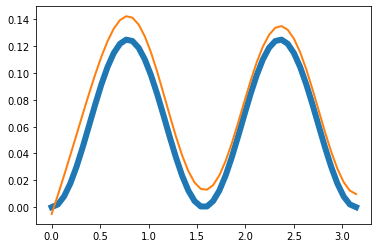

In [59]:
ix = torch.FloatTensor(vx).reshape(vxn,1)
u = mynet(ix)
plt.plot(ix, u_true(ix),  linewidth=6 )
plt.plot(ix, u.detach().numpy(), linewidth=2)

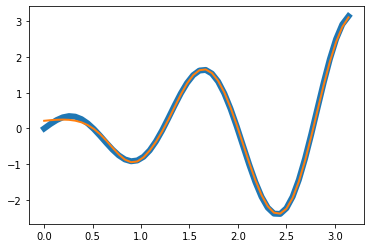

In [55]:
ix = torch.FloatTensor(vx).reshape(vxn,1)
plt.plot(ix, f_true(ix) ,  linewidth=6)
ix.requires_grad = True
du = Du(ix)
du = du.detach()
plt.plot(ix.detach(), du, linewidth=2)


$$
\frac{d}{dx} (x\frac{du}{dx} )~=~ f(x)
$$